In [1]:
import numpy as np
import scipy as sp 
import scipy.special
import matplotlib.pyplot as plt

In [2]:
def derivative_bessel(order, x):
    return sp.special.jvp(order, x)
  

def bessel(order, x):
  return sp.special.jv(order, x)

def derivative_hankel(order, x):
    return sp.special.h1vp(order, x)

def hankel(order, x):
  return sp.special.hankel1(order, x)

def hankel_field(order, amplitude, source_location, position, frequency,speed):
    wavenumber = 2*np.pi*frequency/speed
    return -1j*amplitude/4 * sp.special.hankel1(order, wavenumber * np.linalg.norm(source_location - position))

def planewave_field(amplitude, source_location, position, wavenumbers, frequency,speed):
    direction = wavenumbers / np.linalg.norm(wavenumbers)
    wn = 2*np.pi*frequency/speed
    return amplitude * np.exp(1j*wn* np.dot(position-source_location, direction))
    

def polar(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def plane_wave_expansion_coeffs(order, source_position, center, wavenumbers,frequency, speed):
  coeffs = []
  direction = wavenumbers / np.linalg.norm(wavenumbers)
  field = np.exp(1j*(2*np.pi*frequency)/speed * np.dot(np.array(center) - np.array(source_position), direction))
  theta = np.arctan2(direction[1], direction[0])
  for _ in range(order[0], order[1]+1):
    value = field * np.exp(1j * _ * (-np.pi/2 + theta))
    coeffs.append(value)
  return np.array(coeffs).flatten()

def point_source_expansion_coeffs(order, source_position, center,
                                 amplitude, frequency, speed):
    coeffs = []
    k = (2*np.pi*frequency) /  speed
    r, theta = polar(center[0]-source_position[0], center[1]-source_position[1])
    for _ in range(order[0], order[1]+1):
        coeffs.append(1j*amplitude/4 * hankel(_,k*r) * np.exp(-1j*_*theta))
    return coeffs

def reconstruct_inc(order, coeffs, pos, source_pos, speed, frequency):
    summy = 0
    count = 0
    k = (2*np.pi*frequency) / speed
    position, theta = polar(pos[0] - source_pos[0], pos[1] - source_pos[1])
    for _ in range (order[0], order[1] + 1):
        summy = summy + coeffs[count]*hankel(_, k*position)*np.exp(1j*_*theta)
        count = count + 1
    return summy

def reconstruct_wave(order, coeffs, pos, particle_pos, speed,frequency):
  summy = 0 
  count = 0 
  k = (2*np.pi*frequency) / speed
  position, theta = polar(pos[0]-particle_pos[0], pos[1]-particle_pos[1])
  for _ in range(order[0], order[1]+1):
    summy = summy + coeffs[count]*bessel(_, k*position)*np.exp(1j*_*theta)
    count = count + 1
  return summy

def form_t_matrix(order, background_pressure, background_speed, density, speed, radius, f = 1000, print_q = False):
  diags = []
  q_0 = ((density * speed) / (background_pressure * background_speed))
  if print_q:
    print(q_0)
  k_0 = (2*np.pi*f) / speed
  k = (2*np.pi*f) /  background_speed

    
  for _ in range(order[0], order[1]+1):

    numerator = (q_0 * ((derivative_bessel(_, k*radius) * bessel(_, k_0*radius)) -
                     (bessel(_, k*radius) * derivative_bessel(_, k_0*radius))))

    denominator = (q_0 * derivative_hankel(_, k*radius) * bessel(_, k_0*radius) -
                   hankel(_, k*radius) * derivative_bessel(_, k_0*radius))
    
    diags.append(numerator / denominator)
  
  return np.diag(diags)

def form_big_u(position_1, position_2, k, order_1, order_2):
    position_1 = np.array(position_1)
    position_2 = np.array(position_2)
    R, theta = polar(position_2[0]-position_1[0],position_2[1]-position_1[1])
    
    mat = []
    for i in range(-order_1, order_1+1):
        temp_x = []
        for j in range(-order_2, order_2+1):
            value = hankel((j-i), k*R) * np.exp(1j*((j-i))*theta) #could also be wrong order
            temp_x.append(value)
        mat.append(temp_x)
    return np.array(mat)

def create_matrix(particle_coords, order_1, order_2, 
                  background_pressure, background_speed,
                  density, speed, radius, f = 1000):
    scattering_matrix = []
    k = 2*np.pi*f / background_speed
  
    for part in particle_coords:
        scattering_matrix_x = []
        count = 0
        for part2 in particle_coords:
            if part == part2:
                scattering_matrix_x.append(np.identity((2*order_2+1)))
                count = count + 1
                continue #Kinda assumes order is the same...
            U = form_big_u(part, part2, k, order_1, order_2)
            if isinstance(radius,list):
                
                if len(radius) == len(particle_coords):
                    Tmat = form_t_matrix([-order_1,order_1], background_pressure,
                                  background_speed, density[count],
                                  speed[count], radius[count], f = f) #order could be wrong
                    
            else:
                #Tmat = form_t_matrix([-order_1,order_1], background_pressure,
                #              background_speed, density,
                pass
                #              speed, radius, f = f) #order could be wrong
            scattering_matrix_x.append(-(U.T @ Tmat))
            count = count + 1
        scattering_matrix.append(scattering_matrix_x)
        
    
    return np.block(scattering_matrix)

def solve():
    return 0
          

# Copying the 2 particle example

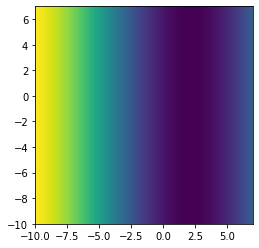

In [3]:
field = []
for i in np.linspace(-4,4,400):
    tempx = []
    for j in np.linspace(-4,0,400):
        tempx.append(planewave_field(1, [2,0],np.array([j,i]),np.array([1,0]),1/(2*np.pi),1))
    field.append(tempx)
plt.imshow(np.real(field),extent=[-10,7,-10,7],origin='lower')

In [4]:
print('lol')

lol


In [5]:
a = np.array([[0,0,0],[0,0,0]]); b = np.array([[1,1,1],[1,1,1]]); c = np.array([[2,2,2],[2,2,2]]); d = np.array([[3,3,3],[3,3,3]])
gmm = np.array([[a,b],[c,d]])
print(gmm.shape)
np.swapaxes(gmm,1,2).reshape(2*2,2*3)

(2, 2, 2, 3)


array([[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [2, 2, 2, 3, 3, 3],
       [2, 2, 2, 3, 3, 3]])

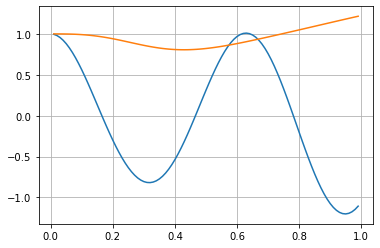

In [7]:
particles = [[-2.0, 2.], [-2., -2.]]
radius = [2., 0.5]
speeds = [2., 2.]
densities = [10., 10.]

SOURCE_LOC = [0., 0.]
EXPANSION = 1
NO_EXPANSIONS = 2*EXPANSION + 1
NO_PARTICLES = len(particles)
DIR = [-1.,0]
BACK_DENS = 1
BACK_SPEED = 1
REC = [-10.,0]

import time

full2 = []
field = []
full3 = []
field2 = []
for w in np.arange(0.01,1,0.01):
    coeffs = []
    for part in particles:
        

        hmm2 = plane_wave_expansion_coeffs([-EXPANSION,EXPANSION],
                                      SOURCE_LOC,
                                      [part[0],
                                       part[1]],
                                      DIR,
                                      w/(2*np.pi),
                                      BACK_SPEED)

        coeffs.append(hmm2)
        
    coeffs = np.array(coeffs)

    scat_mat = create_matrix(particles, EXPANSION,EXPANSION, BACK_DENS, BACK_SPEED, densities, speeds, radius,f = w/(2*np.pi) )
    #test =np.swapaxes(scat_mat,2,1).reshape(NO_EXPANSIONS*NO_PARTICLES,NO_EXPANSIONS*NO_PARTICLES)
    sol = np.linalg.solve(scat_mat,coeffs.flatten())

    reshaped = sol.reshape(NO_PARTICLES,NO_EXPANSIONS)

    T = form_t_matrix([-EXPANSION,EXPANSION], BACK_DENS, BACK_SPEED, densities[0], speeds[0], radius[0],f = w/(2*np.pi), print_q=False)

    T2 = form_t_matrix([-EXPANSION,EXPANSION],BACK_DENS, BACK_SPEED, densities[1], speeds[1], radius[1],f = w/(2*np.pi), print_q=False)
    left_temp =  np.matmul(T,reshaped[0])
    right_temp =  np.matmul(T2,reshaped[1])
    #up_temp =  np.matmul(T,reshaped[2])
    
    val = reconstruct_wave([-EXPANSION,EXPANSION],left_temp, np.array(REC),particles[0], BACK_SPEED, w/(2*np.pi))
    val2 = reconstruct_wave([-EXPANSION,EXPANSION],right_temp, np.array(REC),particles[1], BACK_SPEED, w/(2*np.pi))
    full2.append(val + val2)
    
    val3 = reconstruct_wave([-EXPANSION,EXPANSION],left_temp, np.array([0,0]),particles[0], BACK_SPEED, w/(2*np.pi))
    val4 = reconstruct_wave([-EXPANSION,EXPANSION],right_temp, np.array([0,0]),particles[1], BACK_SPEED, w/(2*np.pi)) 
    full3.append(val4 + val3)
    
    field.append(planewave_field(1, np.array(SOURCE_LOC),np.array(REC),DIR,w/(2*np.pi),BACK_SPEED))
    field2.append(planewave_field(1, np.array(SOURCE_LOC),np.array([0,0]),DIR,w/(2*np.pi),BACK_SPEED))



plt.plot(np.arange(0.01,1,0.01),np.real(np.array(full2)+np.array(field)))
plt.plot(np.arange(0.01,1,0.01),np.real(np.array(full3)+np.array(field2)))
plt.grid()


20.0
20.0
[-0.15824729+0.8814204j   0.71722428-0.34500338j  0.78676601+0.0659751j ]
[ 0.11554096-0.13278183j -0.00016473-0.0870517j  -0.04872837-0.15972041j]


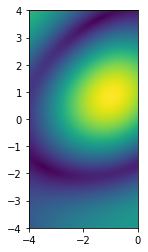

In [8]:
particles = [[-2, 2], [-2, -2]]
radius = [2.5, 0.5]
speeds = [2, 2]
densities = [10, 10]

EXPANSION = 1
NO_EXPANSIONS = 2*EXPANSION + 1
NO_PARTICLES = len(particles)
w = 0.8
FREQ = w/(2*np.pi)

coeffs = []
for part in particles:
    
    hmm = plane_wave_expansion_coeffs([-EXPANSION,EXPANSION],
                                      [1,0],
                                      [part[0],
                                       part[1]],
                                      [1,1],
                                      FREQ,
                                      1)

    coeffs.append(hmm)
coeffs = np.array(coeffs)

scat_mat = create_matrix(particles, EXPANSION,EXPANSION, 1, 1, densities, speeds, radius, f = w/(2*np.pi))
test = scat_mat

sol = np.linalg.solve(test,coeffs.flatten())

reshaped = sol.reshape(NO_PARTICLES,NO_EXPANSIONS)

T = form_t_matrix([-EXPANSION,EXPANSION], 1, 1, densities[0], speeds[0], radius[0],f=w/(2*np.pi),print_q=True)
T2 = form_t_matrix([-EXPANSION,EXPANSION],1, 1, densities[1], speeds[1], radius[1],f=w/(2*np.pi),print_q=True)
left_temp =  np.matmul(T,reshaped[0])
right_temp =  np.matmul(T2,reshaped[1])
#up_temp =  np.matmul(T,reshaped[2])

print(left_temp)
print(right_temp)

full2 = []
for i in np.linspace(-4,4,400):
  tempx = []
  for j in np.linspace(-4,0,400):
    val = reconstruct_wave([-EXPANSION,EXPANSION],left_temp, [j,i],particles[0], 1, FREQ)
    
    val2 = reconstruct_wave([-EXPANSION,EXPANSION],right_temp, [j,i],particles[1], 1, FREQ)
    
    tempx.append(val + val2)
  full2.append(tempx)
plt.imshow((np.abs(np.array(full2)/np.max(np.array(full2)))),extent=[-4,0,-4,4],origin='lower')


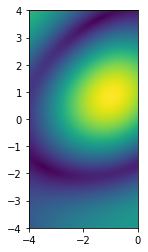

In [9]:
plt.imshow(np.abs(np.array(full2)/np.max(full2)),extent=[-4,0,-4,4],origin='lower')


# Multiple scattering example

In [10]:
particles = [[0, 0.25], [0, -0.25]]
NO_EXPANSIONS = 3
NO_PARTICLES = len(particles)

coeffs = []
for part in particles:
    hmm = point_source_expansion_coeffs([-1,1],
                                    [1,0],
                                    [part[0],part[1]],
                                    1,
                                    1000,
                                    343)
    coeffs.append(hmm)
coeffs = np.array(coeffs)

scat_mat = create_matrix(particles, 1,1, 1.204, 343, 0.0850, 10, 0.1 )

test = np.swapaxes(scat_mat,1,2).reshape(NO_EXPANSIONS*NO_PARTICLES,NO_EXPANSIONS*NO_PARTICLES)

sol = np.linalg.solve(test,coeffs.flatten())

reshaped = sol.reshape(NO_PARTICLES,NO_EXPANSIONS)

T = form_t_matrix([-1,1], 1.204, 343, 0.0850, 100, 0.1,print_q=True)
left_temp =  np.matmul(T,reshaped[0])
right_temp =  np.matmul(T,reshaped[1])
#up_temp =  np.matmul(T,reshaped[2])



full2 = []
for i in np.linspace(-1.5,1.5,200):
  tempx = []
  for j in np.linspace(-1.5,1.5,200):
    val = reconstruct_wave([-1,1],left_temp, [i,j],particles[0], 343, 1000)
    val2 = reconstruct_wave([-1,1],right_temp, [i,j],particles[1], 343, 1000)
    tempx.append(val + val2)
  full2.append(tempx)
plt.imshow(np.imag(np.array(full2)/np.max(np.array(full2))))

UnboundLocalError: local variable 'Tmat' referenced before assignment

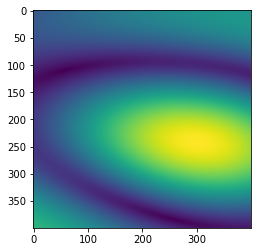

In [11]:
plt.imshow(np.abs(np.array(full2)/np.max(np.array(full2))))

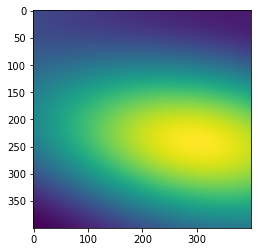

In [12]:
plt.imshow(np.real(np.array(full2)/np.max(np.array(full2))))

# Single Scattering against one particle

In [13]:
plane_wave_expansion_coeffs([0,20],[0,0],[1,0],[0,100],100,343)

array([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

(200, 200)


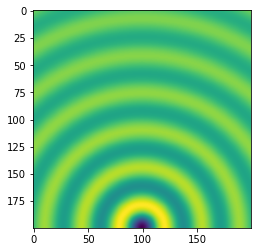

In [14]:
field = []
for i in np.linspace(-2,2,200):
    tempx = []
    for j in np.linspace(-2,2,200):
        if i == 0 and j == 0:
            tempx.append(0 + 1j*0)
        else:
            tempx.append(hankel_field(0,1,np.array([2,0]),np.array([i,j]),500,343))
        
    field.append(tempx)
print(np.shape(field))
plt.imshow(np.imag(field)[:,:])

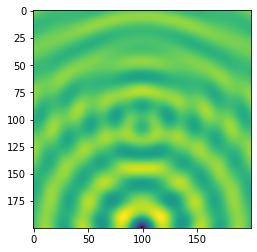

In [15]:
T = form_t_matrix([-3,3], 1.204, 343, 7.850, 5790, 0.1)
temp =  point_source_expansion_coeffs([-3,3],[2,0],[0,0],1,500,343) @ T

full2 = []
for i in np.linspace(-3,3,200):
  tempx = []
  for j in np.linspace(-3,3,200):
    val = reconstruct_wave([-3,3],temp, [i,j],[0,0], 343, 500)
    tempx.append(val)
  full2.append(tempx)
plt.imshow(np.imag(np.array(field)/np.max(np.array(field)) + np.array(full2)/np.max(np.array(full2))))

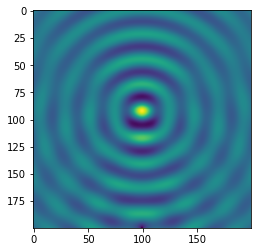

In [16]:
plt.imshow(np.real(field) + np.real(full2)/np.max(np.abs(full2)))

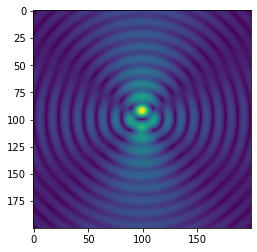

In [17]:
plt.imshow(np.abs(full2))

# Two particles spaced the same as multiple

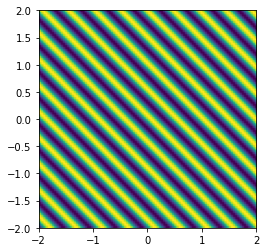

In [18]:
field = []
for i in np.linspace(-2,2,100):
    tempx = []
    for j in np.linspace(-2,2,100):
        tempx.append(planewave_field(1, [2,0],np.array([i,j]),np.array([1,1]),1000,343))
    field.append(tempx)
plt.imshow(np.real(field),extent=[-2,2,-2,2],origin='lower')

In [19]:
T = form_t_matrix([-1,1], 1.204, 343, 7.850, 5790, 0.1)
T = form_t_matrix([-1,1], 1.204, 343, 0.0850, 10, 0.1)

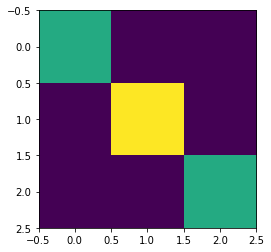

In [20]:
plt.imshow(np.abs(T))

In [21]:

temp =  plane_wave_expansion_coeffs([-1,1],[0,1],[1,0.25],[100,0],1000,343) @ T
temp2 =  plane_wave_expansion_coeffs([-1,1],[0,1],[1,-0.25],[100,0],1000,343) @ T

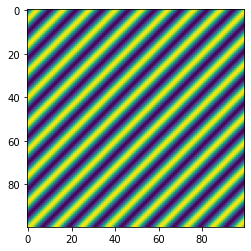

In [22]:
plt.imshow(np.real(np.array(field)/np.max(np.array(field))))

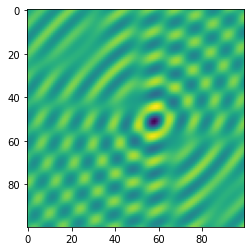

In [23]:
full2 = []
full3 = []
for i in np.linspace(-1.5,1.5,100):
  tempx = []
  tempx2 = []
  for j in np.linspace(-1.5,1.5,100):
    val = reconstruct_wave([-1,1],temp, [i,j],[0,0.25], 343, 1000)
    val2 = reconstruct_wave([-1,1],temp2, [i,j],[0,-0.25], 343, 1000)
    tempx.append(val)
    tempx2.append(val2)
  full2.append(tempx)
  full3.append(tempx2)
plt.imshow(np.imag(np.array(field)/np.max(np.array(field)) + np.array(full2)/np.max(np.array(full2))))

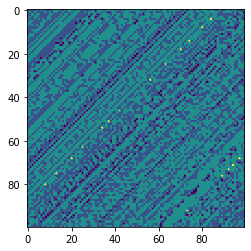

In [24]:
plt.imshow(np.abs(np.array(field)/np.max(np.array(field))))

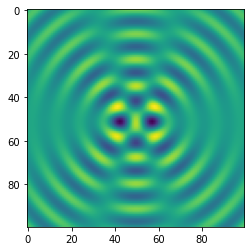

In [25]:
plt.imshow(np.imag(np.array(full2) + np.array(full3)))

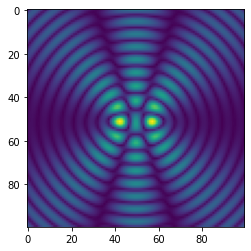

In [26]:
plt.imshow(np.abs(np.array(full2) + np.array(full3)))

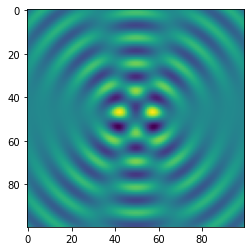

In [27]:
plt.imshow(np.real(np.array(full2) + np.array(full3)))

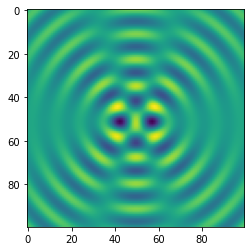

In [28]:
plt.imshow(np.imag(np.array(full2) + np.array(full3)))

# Surfaces

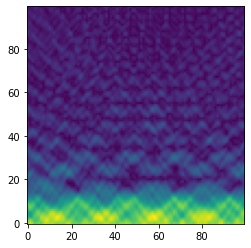

In [29]:
full2 = []
FREQUENCY = 14000
EXPANSION = 1
T = form_t_matrix([-EXPANSION,EXPANSION], 1.204, 343, 7.850, 5790, 0.006)

def sine(x):
    return 0.015*np.sin(2*np.pi/0.05 * x)
for i in np.linspace(0.002,0.5,100):
    tempx = []
    for j in np.linspace(-0.7,0.5,100):
        val = 0 
        for k in np.linspace(-1,1,100):
            
            temp =  plane_wave_expansion_coeffs([-EXPANSION,EXPANSION],
                                    [-0.2,0.22],
                                    [k,sine(k)],
                                    [100,0],
                                    FREQUENCY,
                                    343) @ T
            
            val = val + reconstruct_wave([-EXPANSION,EXPANSION],
                                         temp, 
                                         [j,i],
                                         [k,sine(k)],
                                         343,
                                         FREQUENCY)
        tempx.append(val)
    full2.append(tempx)

plt.imshow(np.abs(np.array(full2)),origin='lower')

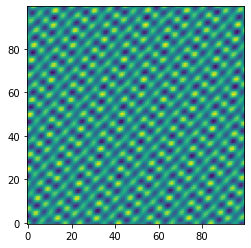

In [30]:
full2 = []
FREQUENCY = 14000
EXPANSION = 1
T = form_t_matrix([-EXPANSION,EXPANSION], 1.204, 343, 7.850, 5790, 0.0245)

def sine(x):
    return 0.015*np.sin(2*np.pi/0.05 * x)
for i in np.linspace(0.1,0.5,100):
    tempx = []
    for j in np.linspace(0.1,0.5,100):
        val = 0 
        for k in np.arange(-1,1,0.0245):
            
            temp =  plane_wave_expansion_coeffs([-EXPANSION,EXPANSION],
                                    [-0.2,0.22],
                                    [k,0],
                                    [-100,100],
                                    FREQUENCY,
                                    343) @ T
            
            val = val + reconstruct_wave([-EXPANSION,EXPANSION],
                                         temp, 
                                         [j,i],
                                         [k,0],
                                         343,
                                         FREQUENCY)
        tempx.append(val)
    full2.append(tempx)

plt.imshow(np.abs(np.array(full2)),origin='lower')

field = []
for i in np.linspace(-2,2,100):
    tempx = []
    for j in np.linspace(-2,2,100):
        tempx.append(planewave_field(1,[-0.2,0.22],np.array([j,i]),np.array([-100,100]),FREQUENCY,343))
    field.append(tempx)
plt.imshow(np.real(field) + np.real(np.array(full2)),origin='lower')

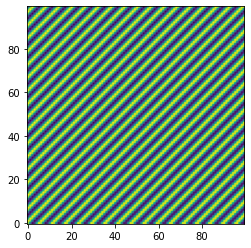

In [31]:
plt.imshow(np.real(field),origin='lower')

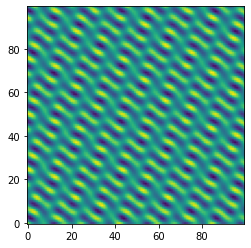

In [32]:
plt.imshow(np.real(np.array(full2)),origin='lower')

(100, 200)


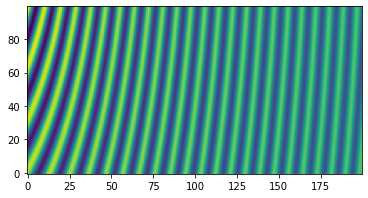

In [33]:
field = []
for i in np.linspace(0.002,0.1,100):
    tempx = []
    for j in np.linspace(-0.1,0.5,200):
        if i == 0.22 and j == -0.2:
            tempx.append(0 + 1j*0)
        else:
            tempx.append(hankel_field(0,1,np.array([0.2,-0.22]),np.array([i,j]),FREQUENCY,343))
        
    field.append(tempx)
print(np.shape(field))
plt.imshow(np.real(field)[:,:],origin='lower')

(100, 100)


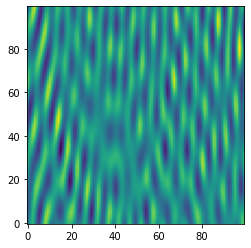

In [34]:
full2 = []
FREQUENCY = 14_000
RADIUS = (343 / FREQUENCY) 
EXPANSION = 1
T = form_t_matrix([-EXPANSION,EXPANSION], 1.204, 343, 7.850, 5790, 0.0245)

def sine(x):
    return 0.0015*np.sin(2*np.pi/0.05 * x)

for i in np.linspace(0.002,0.1,100):
    tempx = []
    for j in np.linspace(0,0.5,100):
        val = 0 
        for k in np.arange(0,1,RADIUS):
            
            
            temp =  point_source_expansion_coeffs([-EXPANSION,EXPANSION],
                                    [0.2,-0.22],
                                    [k,sine(k)],
                                    1,
                                    FREQUENCY,
                                    343) @ T
            
            val = val + reconstruct_wave([-EXPANSION,EXPANSION],
                                         temp, 
                                         [j,i],
                                         [k,sine(k)],
                                         343,
                                         FREQUENCY)
        tempx.append(val)
    full2.append(tempx)



field = []
for i in np.linspace(0.002,0.1,100):
    tempx = []
    for j in np.linspace(0,0.5,100):
        if i == 0.22 and j == -0.2:
            tempx.append(0 + 1j*0)
        else:
            tempx.append(hankel_field(0,1,np.array([0.2,-0.22]),np.array([i,j]),FREQUENCY,343))
        
    field.append(tempx)
print(np.shape(field))
plt.imshow(np.real(np.array(full2)) + np.real(field),origin='lower')

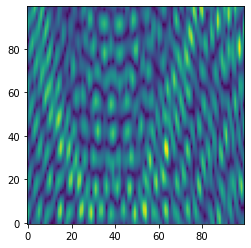

In [35]:
plt.imshow(np.abs(np.array(full2)),origin='lower')

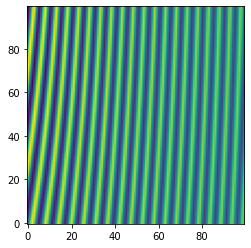

In [36]:
plt.imshow(np.real(field),origin='lower')

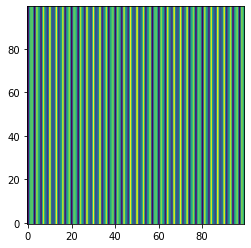

In [37]:
full2 = []
FREQUENCY = 14000
EXPANSION = 2
RADIUS = (343 / FREQUENCY) / 5
T = form_t_matrix([-EXPANSION,EXPANSION], 1.204, 343,0.01, 2, RADIUS)

def sine(x):
    return 0.015*np.sin(2*np.pi/0.05 * x)
for i in np.linspace(-0.5,0.5,100):
    tempx = []
    for j in np.linspace(-0.5,0.5,100):
        val = 0 
        for k in np.arange(-1,1,RADIUS):
            
            if np.abs(k) < 1*RADIUS:
                continue
            
            if j == 0:
                val = 0 + 0 * 1j
                tempx.append(val)
                continue
                
                
            
            temp =  plane_wave_expansion_coeffs([-EXPANSION,EXPANSION],
                                    [5.5,0.0],
                                    [0,k],
                                    [100,0],
                                    FREQUENCY,
                                    343) @ T
            
            val = val + reconstruct_wave([-EXPANSION,EXPANSION],
                                         temp, 
                                         [j,i],
                                         [0,k],
                                         343,
                                         FREQUENCY)
        tempx.append(val)
    full2.append(tempx)

plt.imshow(np.abs(np.array(full2)),origin='lower')

field = []
for i in np.linspace(-2,2,100):
    tempx = []
    for j in np.linspace(-2,2,100):
        tempx.append(planewave_field(1,[-0.2,0.22],np.array([j,i]),np.array([100,0]),FREQUENCY,343))
    field.append(tempx)
plt.imshow(np.real(field) + np.real(np.array(full2)),origin='lower')

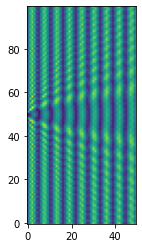

In [38]:
plt.imshow(np.abs(np.array(full2)[:,int(np.shape(full2)[1]/2):]),origin='lower')